## Para gerar os dados Executar o arquivo data.py

## As funções uteis estão no arquivo fuction.py

In [8]:
from fuction import *

In [9]:
# # Caminho para o diretório das imagens
# root_dir = 'data_pendulo'  # Ajuste para o diretório onde suas imagens estão salvas

# # DataLoader
# batch_size = 30
# dataset = CustomImageDataset(root_dir)
# model = SimpleAutoencoder(neck=1)  # Ajuste o parâmetro 'neck' conforme necessário

# trainer = Trainer(model, dataset, batch_size=batch_size,device="cuda")
# trainer.train(epochs=10000)

In [10]:
# trainer.model.eval()  # Coloca o modelo em modo de avaliação

# # Supondo que você quer testar com a primeira imagem do dataset
# dataiter = iter(trainer.dataloader)
# images = next(dataiter)
# # Executar a imagem pela rede
# output,output2 = trainer.model(images[0].unsqueeze(0).to("cuda"))

# # Converte a saída do modelo e a entrada para exibição
# output = output.cpu().detach().numpy().squeeze()
# input_image = images[0].cpu().detach().numpy().squeeze()

# # Plotando as imagens
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(input_image, cmap='gray')
# ax[0].set_title('Imagem Original')
# ax[0].axis('off')
# ax[1].imshow(output, cmap='gray')
# ax[1].set_title('Imagem Reconstruída')
# ax[1].axis('off')
# plt.show()

# Plots do artigo

Treinamento concluído
Treinamento concluído
Treinamento concluído
Treinamento concluído
Treinamento concluído
Treinamento concluído
Treinamento concluído
Treinamento concluído
Treinamento concluído
Treinamento concluído
Treinamento concluído
Treinamento concluído


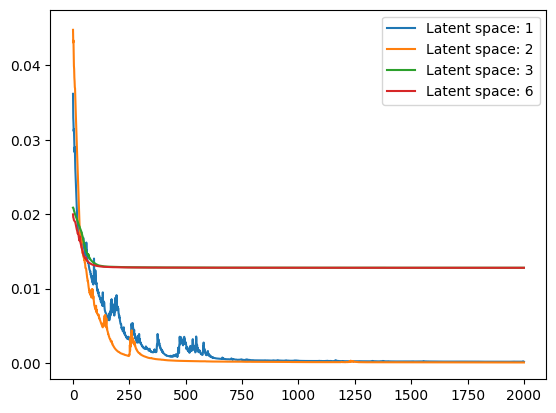

In [11]:
# Caminho para o diretório das imagens
root_dir = 'data_pendulo'  # Ajuste para o diretório onde suas imagens estão salvas
latente_space = [1,2,3,6]
# DataLoader
batch_size  = 30
dataset     = CustomImageDataset(root_dir)
Loss_data   = []
for i in latente_space:
    ram = []
    for _ in range(3):
        model   = SimpleAutoencoder(neck=i)  # Ajuste o parâmetro 'neck' conforme necessário
        trainer = Trainer(model, dataset, batch_size=batch_size,device="cuda",pltrue=False,lr=0.001,step_size=200)
        trainer.train(epochs=2000)
        ram.append(np.array(trainer.losses).reshape(-1,1))  
    Loss_data.append(ram)

count =0
for i in range(np.shape(Loss_data)[0]):
    data  = np.array(Loss_data[i])
    error = data.var(axis=0).reshape(data.shape[1])
    y     = data.mean(axis=0).reshape(data.shape[1])
    x     = np.linspace(0,len(y),len(y))
    
    plt.fill_between(x, y-error, y+error, alpha=0.3)
    plt.plot(x,y,label=f'Latent space: {latente_space[count]}')
    count+=1
plt.legend()
plt.show()

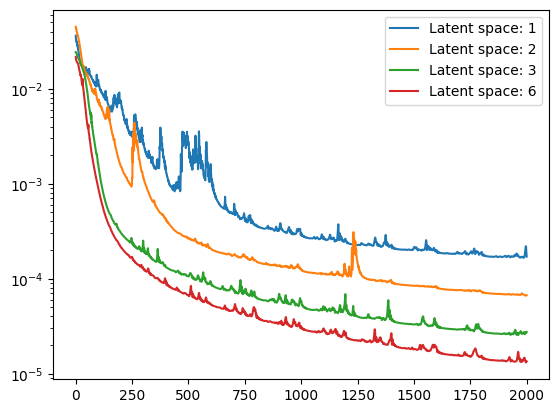

In [17]:
forma  = np.shape(Loss_data)
count = 0
for i in range(len(latente_space)):
    data = np.array(Loss_data[i]).reshape(forma[1], forma[2])  # Ajuste conforme a forma do seu Loss_data
    ram = []
    for ii in range(data.shape[0]):
        # Verificar a variação de cada vetor
        variations = np.ptp(data[ii], axis=0)
        # Filtrar vetores que têm variação maior que o limiar
        if variations > 1e-8:
            ram.append(data[ii])
    
    asd  =2000
    ram  = np.array(ram)
    error = ram.var(axis=0).reshape(data.shape[1])[:asd]
    y     = ram.mean(axis=0).reshape(data.shape[1])[:asd]
    np.savetxt(f"loss_data{i}",y)
    x     = np.linspace(0,len(y),len(y))[:asd]
    
    plt.fill_between(x, y-error, y+error, alpha=0.3)
    plt.plot(x,y,label=f'Latent space: {latente_space[i]}')
    plt.yscale( "log")
    count += 1

plt.legend()
plt.show()